# *Predicting Car Prices*

***In this project, we will predict a car's market price using its attributes. The data set we will be working with contains information on various cars. For each car we have information about the technical aspects of the vehicle such as the motor's displacement, the weight of the car, the miles per gallon, how fast the car accelerates, and more.***

[Download](https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data)
[Documentation](https://archive.ics.uci.edu/ml/datasets/automobile)

***We will be using K-Nearset Neighbors algorithm to predict a Car's price accurately.***

## Exploring Data 

- We will read data into a Dataframe. Since, the data file doesn't come with Header, we need to add proper column names.
- Also, we will drop non-numerical columns which can't be used as features for our model.

In [3]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', 100)

columns  = ['symboling', 'normalized_losses', 'make', 'fuel_type', 'aspiration', 'num_of_doors', 'body_style', 
            'drive_wheels', 'engine_location', 'wheel_base', 'length', 'width', 'height', 'curb_weight', 
            'engine_type', 'num_of_cylinders', 'engine_size', 'fuel_system', 'bore', 'stroke', 
            'compression_ratio', 'horsepower', 'peak_rpm', 'city_mpg', 'highway_mpg', 'price']

cars = pd.read_csv('imports-85.csv', header = None, usecols=[x for x in range(26)], names= columns)
print(cars.shape)
cars.head()

(205, 26)


,symboling,normalized_losses,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,length,width,height,curb_weight,engine_type,num_of_cylinders,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


In [4]:
continuous_values_cols = ['normalized_losses', 'wheel_base', 'length', 'width', 'height', 'curb_weight', 
                          'bore', 'stroke', 'compression_ratio', 'horsepower', 'peak_rpm', 'city_mpg', 
                          'highway_mpg', 'price']

numeric_cars = cars[continuous_values_cols].copy()
numeric_cars.head()

,normalized_losses,wheel_base,length,width,height,curb_weight,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,?,88.6,168.8,64.1,48.8,2548,3.47,2.68,9.0,111,5000,21,27,13495
1,?,88.6,168.8,64.1,48.8,2548,3.47,2.68,9.0,111,5000,21,27,16500
2,?,94.5,171.2,65.5,52.4,2823,2.68,3.47,9.0,154,5000,19,26,16500
3,164,99.8,176.6,66.2,54.3,2337,3.19,3.40,10.0,102,5500,24,30,13950
4,164,99.4,176.6,66.4,54.3,2824,3.19,3.40,8.0,115,5500,18,22,17450


## Data Cleaning

For Data Cleaning, we will perform the following steps:

- Replace missing and meaningless values like `?` with np.nan
- Convert String columns (which are actually numeric) to Numeric datatype
- Drop rows where missing/np.nan values will effect data/prediction
- Replace missing/np.nan values for other places using the average values from that column.
- Normalize the Dataframe except Price Column

In [5]:
numeric_cars.replace('?', np.nan, inplace=True)
numeric_cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 14 columns):
normalized_losses    164 non-null object
wheel_base           205 non-null float64
length               205 non-null float64
width                205 non-null float64
height               205 non-null float64
curb_weight          205 non-null int64
bore                 201 non-null object
stroke               201 non-null object
compression_ratio    205 non-null float64
horsepower           203 non-null object
peak_rpm             203 non-null object
city_mpg             205 non-null int64
highway_mpg          205 non-null int64
price                201 non-null object
dtypes: float64(5), int64(3), object(6)
memory usage: 22.5+ KB


- There are few null values in several columns. We will address them next.
- But first we need to convert Columns (which area actually numeric) from  String/Object datatype  to numeric type


In [6]:
numeric_cars = numeric_cars.astype('float')
numeric_cars.isnull().sum()

normalized_losses    41
wheel_base            0
length                0
width                 0
height                0
curb_weight           0
bore                  4
stroke                4
compression_ratio     0
horsepower            2
peak_rpm              2
city_mpg              0
highway_mpg           0
price                 4
dtype: int64

- Because `price` is the column we want to predict, let's remove any rows with missing `price` values.

In [7]:
numeric_cars.dropna(subset=['price'], inplace=True)
numeric_cars['price'].isnull().sum() # Checking if therre is any null value

0

- Replace missing values in other columns using their respective column means.

In [8]:
numeric_cars.fillna(numeric_cars.mean(), inplace=True)
numeric_cars.isnull().sum()

normalized_losses    0
wheel_base           0
length               0
width                0
height               0
curb_weight          0
bore                 0
stroke               0
compression_ratio    0
horsepower           0
peak_rpm             0
city_mpg             0
highway_mpg          0
price                0
dtype: int64

- Normalizing The Dataframe

In [9]:
normalised_cars = (numeric_cars.max() - numeric_cars)/numeric_cars.max()
normalised_cars['price'] = numeric_cars['price']
normalised_cars.head()

,normalized_losses,wheel_base,length,width,height,curb_weight,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,0.523438,0.267163,0.188852,0.109722,0.183946,0.373340,0.119289,0.357314,0.608696,0.576336,0.242424,0.571429,0.500000,13495.0
1,0.523438,0.267163,0.188852,0.109722,0.183946,0.373340,0.119289,0.357314,0.608696,0.576336,0.242424,0.571429,0.500000,16500.0
2,0.523438,0.218362,0.177319,0.090278,0.123746,0.305706,0.319797,0.167866,0.608696,0.412214,0.242424,0.612245,0.518519,16500.0
3,0.359375,0.174524,0.151370,0.080556,0.091973,0.425234,0.190355,0.184652,0.565217,0.610687,0.166667,0.510204,0.444444,13950.0
4,0.359375,0.177833,0.151370,0.077778,0.091973,0.305460,0.190355,0.184652,0.652174,0.561069,0.166667,0.632653,0.592593,17450.0


## Univariate Model

- We will start modelling our prediction model from here in a step-by-step manner. 
- First We need to evaluate which features give us the most accurate prediction.

***We will create a `knn_train_test` function to train and test univariate models using different numeric columns in the data set.***

In [10]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

def knn_train_test(feature, target, df):
    
    # Fit the model
    knn = KNeighborsRegressor()
    
    # Randomizing the Dataset
    np.random.seed(1)
    new_df = df.iloc[np.random.permutation(len(df))].copy()
    
    # Divide the data in half
    train_df = new_df[:100]
    test_df = new_df[100:]
    
    # Fit a KNN Model using default K value
    knn.fit(train_df[[feature]], train_df[target])
    
    # Making predictions using the model
    predictions = knn.predict(test_df[[feature]])
    
    # Calculate and return RMSE Value
    rmse = np.sqrt(mean_squared_error(test_df[target], predictions))
    return rmse    
    
# Extracting all feature names except price 
columns  = normalised_cars.columns.tolist()
columns.remove('price')

# Create a dictionary of RMSE Values aling with Features
rmse_results = {}

for col in columns:
    rmse  = knn_train_test(col, 'price', normalised_cars)
    rmse_results[col] = rmse

# Converting dictionary into Series and sorting it to display results
rmse_results = pd.Series(rmse_results)    
rmse_results.sort_values()

horsepower           4007.472352
curb_weight          4437.934395
highway_mpg          4579.037250
width                4644.898429
city_mpg             4729.673421
length               5382.671155
wheel_base           5527.682489
compression_ratio    6736.676353
bore                 6816.853712
height               7487.652519
peak_rpm             7498.746475
normalized_losses    7635.170416
stroke               8078.491289
dtype: float64


- It looks like `horsepower` feature gives us the least amount of error. But, we need explore further. 

***Next, Modifying the `knn_train_test()` function to accept `k` value as a parameter. <br>Creating, training, and testing a univariate model using following `k` values `(1, 3, 5, 7, and 9)`.***

In [11]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

def knn_train_test2(feature, target, df, k_value):
    # Randomizing the Dataset
    np.random.seed(1)
    new_df = df.iloc[np.random.permutation(len(df))].copy()
    
    # Divide the data in half
    train_df = new_df[:100]
    test_df = new_df[100:]
    
    # Fitting the model wih k neighbors
    knn = KNeighborsRegressor(n_neighbors=k_value)
    knn.fit(train_df[[feature]], train_df[target])
    
    # Making predictions using the model
    predictions = knn.predict(test_df[[feature]])

    # Calculate and return RMSE Value
    rmse = np.sqrt(mean_squared_error(test_df[target], predictions))
    return rmse
    
# Extracting all feature names except price
columns  = normalised_cars.columns.tolist()
columns.remove('price')

# K Nearest Neighbors
k_values = [1, 3, 5, 7, 9]

# Create a dictionary of RMSE Values along with Features
k_rmse_results = {}

# Looping through all the features
for col in columns:
    k_results = []
    for k in k_values:
        rmse_k  = knn_train_test2(col, 'price', normalised_cars, k)
        k_results.append(rmse_k)
    k_rmse_results[col] = k_results
    
# Converting dictionary into Series and sorting it to display results
# rmse_results = pd.Series(rmse_results)    
# rmse_results.sort_values()
k_rmse_results

{'normalized_losses': [7906.594141025014,
  6712.873355379836,
  7635.170416092379,
  7870.651003239241,
  8221.578465544319],
 'wheel_base': [5964.682235317891,
  5246.472910232148,
  5527.682488732292,
  5485.683033525724,
  5734.4339857054465],
 'length': [5291.785164547288,
  5267.216777678541,
  5382.671155138166,
  5396.362242025737,
  5420.547916432259],
 'width': [4453.161424568767,
  4697.287114550659,
  4644.898428543422,
  4562.1341847495605,
  4643.882339393336],
 'height': [9108.471836593655,
  8049.98714728832,
  7487.652518884965,
  7753.797418084058,
  7695.632426557866],
 'curb_weight': [5518.883237405808,
  5048.607726036669,
  4437.934394635539,
  4369.349089851214,
  4632.205545221074],
 'bore': [7496.149231240644,
  6936.9888741632,
  6816.8537123691885,
  7062.061305053834,
  6869.727437364902],
 'stroke': [7282.34885878108,
  7664.984030806539,
  8078.491288735677,
  7754.483859461689,
  7723.913153845065],
 'compression_ratio': [9024.902677953633,
  7033.5529229

***Visualising `RMSE`s for various `K` and `Features`***

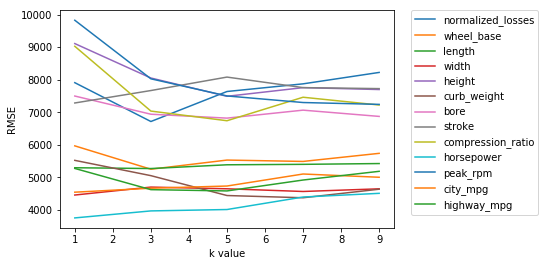

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

# plt.figs

for k,v in k_rmse_results.items():
    x = [1, 3, 5, 7, 9]
    y = v
    
    plt.plot(x, y, label=k)
    plt.xlabel('k value')
    plt.ylabel('RMSE')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.show()

- The Visualisation isn't very helpful. Let's arrange the Average of `RMSE (Root Mean Squared Error)`s and `Features` in a sorted manner. 

***Finding best `features` with lowest `RMSE`s (Errors)***

In [13]:
feature_rmse = {}

for k,v in k_rmse_results.items():
    avg_rmse = np.mean(v)
    feature_rmse[k] = avg_rmse
    
pd.Series(feature_rmse).sort_values()

horsepower           4123.737847
width                4600.272698
curb_weight          4801.395999
city_mpg             4806.213763
highway_mpg          4912.751353
length               5351.716651
wheel_base           5591.790931
bore                 7036.356112
compression_ratio    7494.726126
normalized_losses    7669.373476
stroke               7700.844238
peak_rpm             7977.094835
height               8019.108269
dtype: float64

- The above table reiterates our finding from our earlier that `horsepower` gives least amount of error.

## Multivariate Model

- While Univariate Models deal with a single feature at a time. We need Multiple Columns to make our predictions more robust.

***Now, we will optimize `knn_train_test` function to work along with multiple columns.***

In [14]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

def knn_train_test3(features, target, df):
    # Randomizing the Dataset
    np.random.seed(1)
#     new_df = df.iloc[np.random.permutation(len(df))].copy()
    shuffled_index = np.random.permutation(df.index)
    new_df = df.reindex(shuffled_index)
    
    # Divide the data in half
    train_df = new_df.iloc[:100]
    test_df = new_df.iloc[100:]
    
    # Fitting the model wih k neighbors
    knn = KNeighborsRegressor()
    knn.fit(train_df[features], train_df[target])
    
    # Making predictions using the model
    predictions = knn.predict(test_df[features])

    # Calculate and return RMSE Value
    rmse = np.sqrt(mean_squared_error(test_df[target], predictions))
    return rmse

# Create a dictionary of RMSE Values along with Feature numbers for Multivariate Model
rmse_results = {}

# Training and Testing on all the features 
columns  = normalised_cars.columns.drop('price')
rmse_results['All Features'] = knn_train_test3(columns, 'price', normalised_cars)

# Training and Testing on top two features 
columns = ['horsepower', 'width']
rmse_results['Top Two Features'] = knn_train_test3(columns, 'price', normalised_cars)

# Training and Testing on top three features 
columns = ['horsepower', 'width', 'curb_weight']
rmse_results['Top Three Features']  = knn_train_test3(columns, 'price', normalised_cars)

# Training and Testing on top four features 
columns = ['horsepower', 'width', 'curb_weight', 'city_mpg']
rmse_results['Top Four Features'] = knn_train_test3(columns, 'price', normalised_cars)

# Training and Testing on top five features 
columns = ['horsepower', 'width', 'curb_weight', 'city_mpg', 'highway_mpg']
rmse_results['Top Five Features'] = knn_train_test3(columns, 'price', normalised_cars)

# Displaying results sorted as per the RMSEs
pd.Series(rmse_results).sort_values()

Top Three Features    3212.559631
Top Four Features     3232.103629
Top Five Features     3346.673710
All Features          3525.979140
Top Two Features      3681.398092
dtype: float64

- We got the least error by using model comprised of Top `Three Features` (`horsepower`, `width`, `curb_weight`).
- Next, we have lesser accurate model by adding `city_mpg` and then `highway_mpg` features.

## Hyperparameter Tuning

- After `feature selection`, we need to work on `hyperparameters` (like `n_neighbors`) which are unrelated to data, but have an effect on performance of model's accuracy and performance.

***Now, we will optimize the least error prone feature sets from previous step by tuning the value of `k`.***

In [15]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

def knn_train_test_hyp(features, target, df, k):
    # Randomizing the Dataset
    np.random.seed(1)
#     new_df = df.iloc[np.random.permutation(len(df))].copy()
    shuffled_index = np.random.permutation(df.index)
    new_df = df.reindex(shuffled_index)
    
    # Divide the data in half
    train_df = new_df.iloc[0:101]
    test_df = new_df.iloc[101:]
    
    # Fitting the model wih k neighbors
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(train_df[features], train_df[target])
    
    # Making predictions using the model
    predictions = knn.predict(test_df[features])

    # Calculate and return RMSE Value
    rmse = np.sqrt(mean_squared_error(test_df[target], predictions))
    return rmse

# Training and Testing on all, five and four features

top_three_features = ['horsepower', 'width', 'curb_weight']
top_four_features = ['horsepower', 'width', 'curb_weight', 'city_mpg']
top_five_features = ['horsepower', 'width', 'curb_weight', 'city_mpg', 'highway_mpg']

columns = [top_three_features, top_four_features, top_five_features]
col_names = ['top three', 'top four', 'top five']

k_values = [x for x in range(1, 26)]

# Create a dictionary of RMSE Values along with Feature numbers for Multivariate Model
rmse_results = {}

counter = 0

for col in columns:
    k_results = []
    for k in k_values:
        rmse = knn_train_test_hyp(col, 'price', normalised_cars, k)
        k_results.append(rmse)
    
    rmse_results['{} features'.format(col_names[counter])] = k_results
    counter += 1
    
rmse_results

{'top three features': [3323.59435551332,
  3058.74782549984,
  3056.2545523710696,
  2975.407887059352,
  3227.0822275238047,
  3559.2544344130397,
  3818.8173516556303,
  4028.465781376174,
  4098.315949084273,
  4256.290788491782,
  4355.581824025939,
  4438.3388263124725,
  4513.686379323177,
  4561.3588919502345,
  4636.746517342617,
  4673.56519448583,
  4731.684255118721,
  4674.779477396121,
  4640.952875797594,
  4683.495361610279,
  4670.369439613065,
  4626.772114400605,
  4663.4682993716015,
  4685.349603638555,
  4737.194810521519],
 'top four features': [3059.5827836487774,
  2462.3477765133016,
  2768.7774837361785,
  2953.53157539834,
  3231.7713493376973,
  3568.5760427733007,
  3849.9768127846683,
  3930.865082209163,
  4096.986533093033,
  4216.70470801549,
  4348.117219228198,
  4466.370522956344,
  4572.152598428186,
  4613.055952369738,
  4647.299051511295,
  4723.6510123592425,
  4716.0329460103085,
  4726.23225935004,
  4716.361756276387,
  4762.366524594154,
  

***Visualizing above data on a Line Chart***

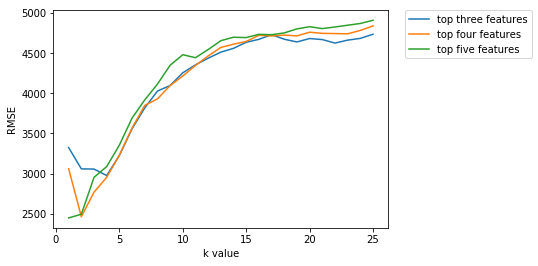

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
from numpy import arange

labels = ['{} features'.format(x) for x in col_names]

for k,v in rmse_results.items():
    x = np.arange(1, 26, 1)
    y = v
    
    plt.plot(x, y)
    plt.xlabel('k value')
    plt.ylabel('RMSE')

plt.legend(labels=labels, bbox_to_anchor=(1.05, 1), borderaxespad=0)
plt.show()

***Finding best `k-value` and `Feature Set`***

In [60]:
# Getting average RMSE across different `k` values for each feature.
k_rmse = {}

for k,v in rmse_results.items():
    min_rmse = np.min(v)
    min_k = v.index(min_rmse)+1
    k_rmse[k] = min_k, min_rmse
    
pd.Series(k_rmse).sort_values()

top five features     (1, 2447.3294159144166)
top four features     (2, 2462.3477765133016)
top three features     (4, 2975.407887059352)
dtype: object

Here, we can see that we get most accuracy by using:
- `k`-value of `1` for `5 features` set of (`horsepower`, `width`, `curb_weight`, `city_mpg` and `highway_mpg`)
- lesser by `k`-value of `2` for `4 features` / one feature less from the end
- lesser by `k`-value of `4` for `3 features`/ two features less from the end

Since, k = 1 may lead to overfitting we can model our predictions on k = 2 or k = 4. 

### K-Fold Cross Validation

- We will do `cross validation` with `Scikit-Learn` to compare or check accuracy of our machine learning model. And, then we can us the model will least Avg. `Root Suare Mean Error` for predictions.

In [17]:
from sklearn.model_selection import cross_val_score, KFold

num_folds = [3, 5, 7, 9, 10, 11, 13, 15, 17, 19, 21, 23]

for fold in num_folds:
    kf = KFold(fold, shuffle=True, random_state=1)
    knn = KNeighborsRegressor(n_neighbors=2)
    mses = cross_val_score(knn, normalised_cars[top_four_features], normalised_cars["price"], 
                           scoring="neg_mean_squared_error", cv=kf)
    rmses = np.sqrt(np.absolute(mses))
    avg_rmse = np.mean(rmses)
    std_rmse = np.std(rmses)
    print(str(fold), "folds: ", "avg RMSE: ", str(avg_rmse), "std RMSE: ", str(std_rmse))

3 folds:  avg RMSE:  2721.1482553493674 std RMSE:  454.21530062792544
5 folds:  avg RMSE:  2650.2948055326297 std RMSE:  671.9956944809293
7 folds:  avg RMSE:  2605.3801535031566 std RMSE:  647.7122348517307
9 folds:  avg RMSE:  2460.825450999697 std RMSE:  834.0447649078803
10 folds:  avg RMSE:  2601.03838140748 std RMSE:  785.0526436654494
11 folds:  avg RMSE:  2586.700719662456 std RMSE:  793.1450860934392
13 folds:  avg RMSE:  2670.410517313722 std RMSE:  844.9813541208631
15 folds:  avg RMSE:  2478.254375759172 std RMSE:  1029.435255015396
17 folds:  avg RMSE:  2496.3844361858164 std RMSE:  871.9542486776757
19 folds:  avg RMSE:  2551.093086597125 std RMSE:  964.0507025343769
21 folds:  avg RMSE:  2416.1197865515837 std RMSE:  1020.4286722009539
23 folds:  avg RMSE:  2489.7964585686136 std RMSE:  1076.3081178243528


***Here, we can observe that some of the least error is shown when `folds(data divisions) = 5` and we're using `k = 2` along with top four features, which are `horsepower, width, curb_weight and city_mpg`.***

***This information will help us in predicting car prices accurately, given their aforementioned features.***